#Купил значит я себе рахат-лукум, как в Греции

In [ ]:
!pip install catboost # Теперь я вич инфецированный
!pip install unrar

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [139]:
import numpy as np
import pandas as pd
import math
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib.pyplot as plt

In [1]:
!unzip /content/drive/MyDrive/Попытки-в-Catboost/new-york-city-taxi-fare-prediction.zip

unzip:  cannot find or open /content/drive/MyDrive/Попытки-в-Catboost/new-york-city-taxi-fare-prediction.zip, /content/drive/MyDrive/Попытки-в-Catboost/new-york-city-taxi-fare-prediction.zip.zip or /content/drive/MyDrive/Попытки-в-Catboost/new-york-city-taxi-fare-prediction.zip.ZIP.


In [140]:
# Функция для расчета расстояния между координатами
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Радиус Земли в километрах
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

In [157]:
# Загрузка данных
data = pd.read_csv('new-york-city-taxi-fare-prediction/train.csv', nrows=2000000)
data = data.dropna() # Убираем пустые значения

In [158]:
# Преобразование даты и времени
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce')
data = data.dropna(subset=['pickup_datetime'])

In [159]:
# Создание временных признаков
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour'] = data['pickup_datetime'].dt.hour

In [160]:
# Создание признака расстояния
data['distance'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'],
                                      data['dropoff_latitude'], data['dropoff_longitude'])

In [161]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance
count,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06
mean,1.134768e+01,-7.252324e+01,3.992965e+01,-7.252395e+01,3.992808e+01,1.684125e+00,2.011740e+03,6.267687e+00,1.571031e+01,3.041727e+00,1.350827e+01,1.952825e+01
std,9.852609e+00,1.286798e+01,7.983330e+00,1.277497e+01,1.032382e+01,1.314979e+00,1.860588e+00,3.436747e+00,8.681900e+00,1.949844e+00,6.515764e+00,3.677960e+02
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00,2.010000e+03,3.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00,1.212743e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00,2.012000e+03,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01,2.116157e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00,2.013000e+03,9.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01,3.880093e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02,2.015000e+03,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,1.733020e+04


In [162]:
#Загрузка данных ключевых точек
key_points = pd.read_csv('interes_points.csv')
key_points

,type,name,latitude,longitude
0,Airport,Guardia,40.775235,-73.874517
1,Airport,John F. Kennedy International Airport,40.642100,-73.789290
2,Railway station,Grand Central Station,40.752631,-73.977364


In [163]:
# Создание признака раccтояния до ключевых точек

pn = key_points[['latitude', 'longitude']].values
for i in range(len(pn)):

    elem = pn[i]
    data[f'distance_{i}'] = haversine_distance(data['pickup_longitude'], data['pickup_latitude'], elem[0], elem[1])


In [164]:
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,distance_0,distance_1,distance_2
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,1.030764,15082.865136,15066.465383,15083.655389
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,8.450134,15079.229220,15062.835267,15079.981662
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,1.389525,15081.388879,15064.993861,15082.148128
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,2.799270,15080.453532,15064.058617,15081.212119
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,1.999157,15081.879242,15065.483732,15082.641650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,2014-11-17 13:51:02.0000002,4.0,2014-11-17 13:51:02+00:00,-73.950787,40.770836,-73.951043,40.774543,1,2014,11,17,0,13,0.412763,15082.303368,15065.907272,15083.069566
1999996,2013-02-25 17:51:28.0000004,7.0,2013-02-25 17:51:28+00:00,-73.983035,40.748276,-73.974725,40.741978,1,2013,2,25,0,17,0.990211,15080.990619,15064.595589,15081.749944
1999997,2013-07-12 22:03:41.0000006,10.5,2013-07-12 22:03:41+00:00,-74.003482,40.743577,-73.976758,40.765265,1,2013,7,12,4,22,3.298915,15080.448390,15064.054057,15081.203253
1999998,2009-01-17 09:35:37.0000002,10.9,2009-01-17 09:35:37+00:00,-73.971819,40.797243,-73.985921,40.752459,3,2009,1,17,5,9,5.119378,15082.689828,15066.294496,15083.451093


In [165]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'year', 'month', 'day', 'day_of_week', 'hour', 'distance', 'distance_0', 'distance_1', 'distance_2'] #, 'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7', 'distance_8', 'distance_9']
target = 'fare_amount'
X = data[features]
y = data[target]

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
# Создание и обучение модели
model = CatBoostRegressor(iterations=1500, learning_rate=0.08, depth=10, l2_leaf_reg = 5, loss_function='RMSE', verbose=100, random_seed=52)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)

0:	learn: 9.3030803	test: 9.2284686	best: 9.2284686 (0)	total: 155ms	remaining: 3m 51s
100:	learn: 4.3965315	test: 4.3284760	best: 4.3284760 (100)	total: 9.23s	remaining: 2m 7s
200:	learn: 4.2152234	test: 4.2327861	best: 4.2327861 (200)	total: 18.1s	remaining: 1m 56s
300:	learn: 4.1054147	test: 4.1955952	best: 4.1955952 (300)	total: 26.9s	remaining: 1m 47s
400:	learn: 4.0248853	test: 4.1724818	best: 4.1724818 (400)	total: 35.8s	remaining: 1m 38s
500:	learn: 3.9587435	test: 4.1593128	best: 4.1592642 (499)	total: 44.6s	remaining: 1m 28s
600:	learn: 3.9065375	test: 4.1476913	best: 4.1476305 (598)	total: 53.2s	remaining: 1m 19s
700:	learn: 3.8592871	test: 4.1440069	best: 4.1440066 (699)	total: 1m 1s	remaining: 1m 10s
800:	learn: 3.8177259	test: 4.1398917	best: 4.1398917 (800)	total: 1m 10s	remaining: 1m 1s
900:	learn: 3.7795393	test: 4.1372158	best: 4.1372158 (900)	total: 1m 19s	remaining: 52.6s
1000:	learn: 3.7465362	test: 4.1344660	best: 4.1344660 (1000)	total: 1m 27s	remaining: 43.7s
11

Text(0.5, 1.0, 'Feature Importance')

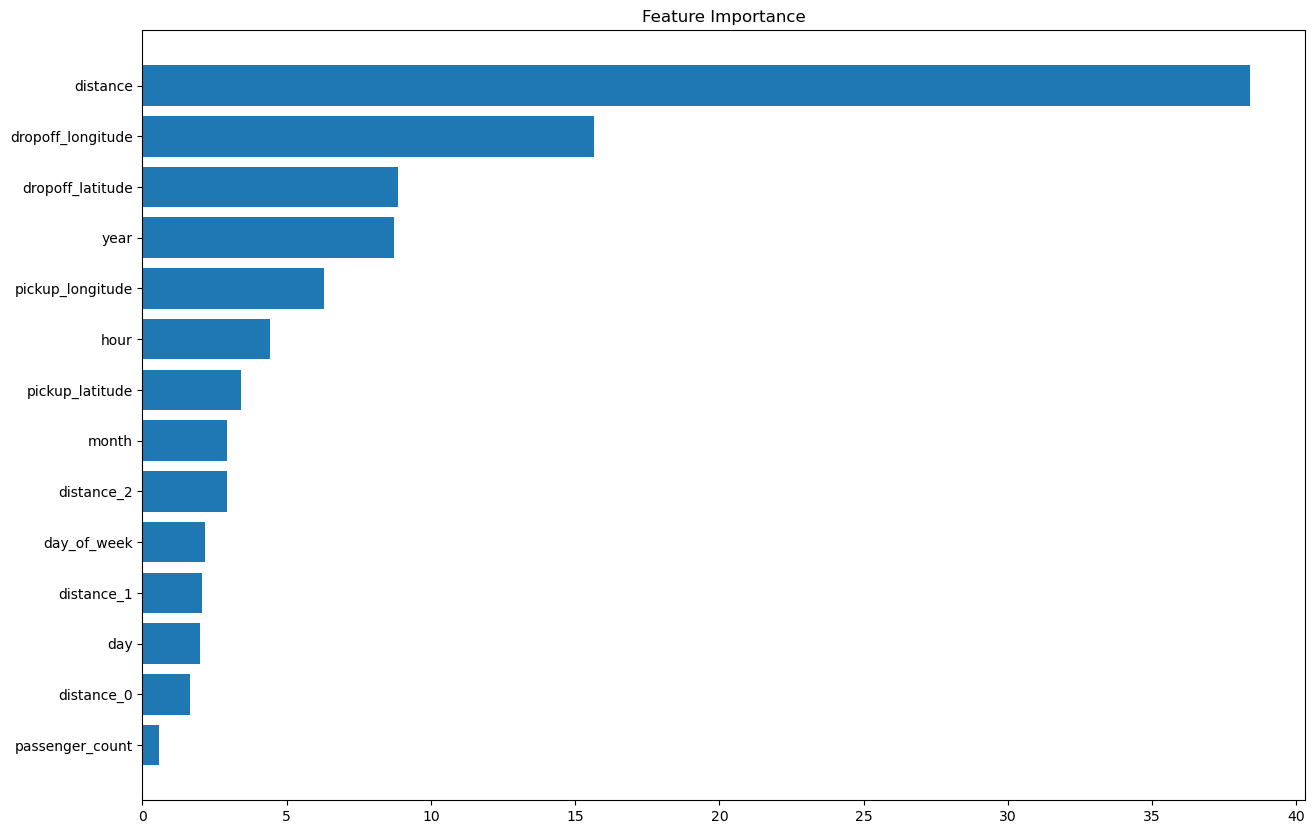

In [173]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')


In [174]:
# Оценка модели 
y_pred = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE на тестовой выборке: {rmse:.2f}")

RMSE на тестовой выборке: 4.12


In [175]:
# Загрузка тестовых данных
test_data = pd.read_csv('new-york-city-taxi-fare-prediction/test.csv')

# Предобработка тестовых данных
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'], errors='coerce')
test_data['year'] = test_data['pickup_datetime'].dt.year
test_data['month'] = test_data['pickup_datetime'].dt.month
test_data['day'] = test_data['pickup_datetime'].dt.day
test_data['day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
test_data['hour'] = test_data['pickup_datetime'].dt.hour

test_data['distance'] = haversine_distance(test_data['pickup_latitude'], test_data['pickup_longitude'],
                                      test_data['dropoff_latitude'], test_data['dropoff_longitude'])

In [176]:
# Создание признака раccтояния до ключевых точек

pn = key_points[['latitude', 'longitude']].values
for i in range(len(pn)):

    elem = pn[i]
    test_data[f'distance_{i}'] = haversine_distance(test_data['pickup_longitude'], test_data['pickup_latitude'], elem[0], elem[1])


In [177]:
predictions = model.predict(test_data[features]) # ТО САМОЕ ПРЕДСКАЗАНИЕ

# Создаем DataFrame для отправки
submission = pd.DataFrame({
    'key': test_data['key'],
    'fare_amount': predictions
    })

# Сохранение результатов
submission.to_csv('taxi_fare_submission.csv', index=False)
print("Файл taxi_fare_submission.csv успешно создан.")

Файл taxi_fare_submission.csv успешно создан.
